# NYFed Financial Conditions Indicator

Reviewing OOP Data Collection and some sample plots

# Packages

In [28]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Create Object Instance and use method to get the data

In [2]:
from collect import *

In [3]:
ny_fed_collect = NYFedCollect()
#ny_fed_collect.collect()

We can always use the get_df method, or you can read file from wherever it was saved in directory

In [4]:
df = ny_fed_collect.get_df()

In [5]:
df.head()

variable,date,fci_baseline,fci_rolling_year
0,1993-01-29,-0.550522,-0.074002
1,1999-01-29,-0.829646,-0.559776
2,2010-01-29,0.194364,-1.170552
3,2016-01-29,0.486614,0.503353
4,2021-01-29,-1.380014,-1.100960


# Sample Line Plots

There is a member class attribute which stores the column names in a dictionary for data mamipulation, and there is also an inverted dictionary used for flipping column names back when we plot

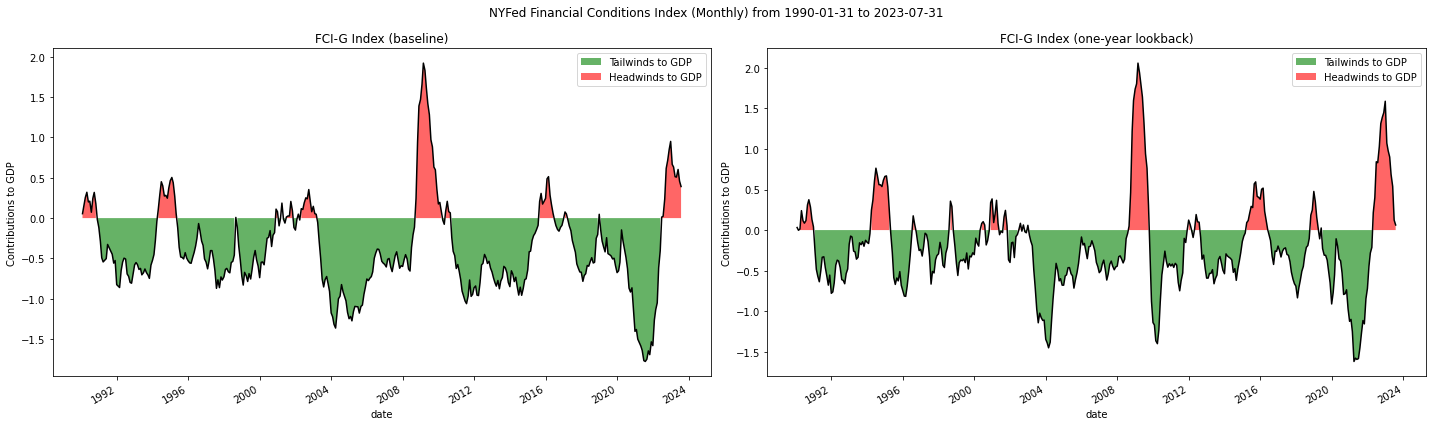

In [31]:
df_plot = (df.set_index(
    "date").
    sort_index().
    rename(columns = ny_fed_collect.inv_column_renamer))

fig, axes = plt.subplots(ncols = 2, figsize = (20, 6))
for i, col in enumerate(df_plot.columns):
    (df_plot[
        col].
        plot(
            ax = axes[i],
            color = "black",
            title = col,
            ylabel = "Contributions to GDP"))
    
    axes[i].fill_between(
        x = df_plot.index,
        y1 = df_plot[col],
        y2 = 0,
        where = df_plot[col] < 0,
        facecolor = "green",
        alpha = 0.6)
    
    axes[i].fill_between(
        x = df_plot.index,
        y1 = df_plot[col],
        y2 = 0,
        where = df_plot[col] > 0,
        facecolor = "red",
        alpha = 0.6)
    
    legend_elements = [
        Patch(facecolor = "green", alpha = 0.6, label = "Tailwinds to GDP"),
        Patch(facecolor = "red", alpha = 0.6, label = "Headwinds to GDP")]

    axes[i].legend(handles = legend_elements)
    
fig.suptitle("NYFed Financial Conditions Index (Monthly) from {} to {}".format(
    df_plot.index.min().date(),
    df_plot.index.max().date()))

plt.tight_layout()
plt.show()

In [51]:
df_spread = (df.assign(
    spread = lambda x: x.fci_baseline - x.fci_rolling_year).
    set_index("date").
    sort_index())

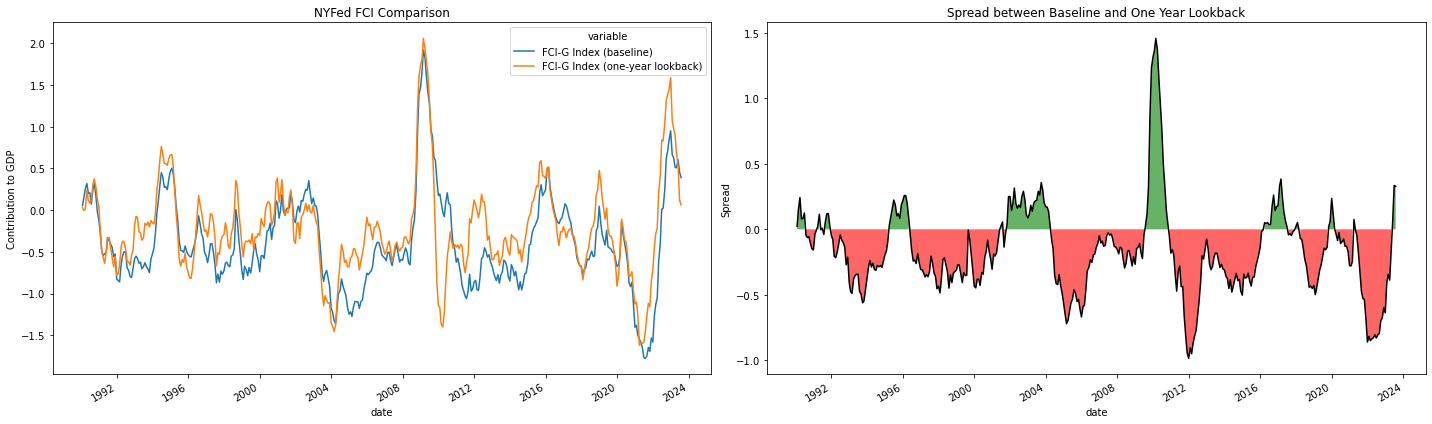

In [59]:
fig, axes = plt.subplots(ncols = 2, figsize = (20, 6))

(df_spread[
    list(ny_fed_collect.inv_column_renamer.keys())].
    rename(columns = ny_fed_collect.inv_column_renamer).
    plot(
        ax = axes[0],
        title = "NYFed FCI Comparison",
        ylabel = "Contribution to GDP"))

(df_spread[
    "spread"].
    plot(
        ax = axes[1],
        title = "Spread between Baseline and One Year Lookback",
        ylabel = "Spread",
        color = "black"))

axes[1].fill_between(
    x = df_spread.index,
    y1 = df_spread.spread,
    y2 = 0,
    where = df_spread.spread > 0,
    facecolor = "green",
    alpha = 0.6)

axes[1].fill_between(
    x = df_spread.index,
    y1 = df_spread.spread,
    y2 = 0,
    where = df_spread.spread < 0,
    facecolor = "red",
    alpha = 0.6)

plt.tight_layout()
plt.show()

# Sample Histogram Plots

In [65]:
df_pct_change = (df_spread.pct_change().rename(
    columns = ny_fed_collect.inv_column_renamer))

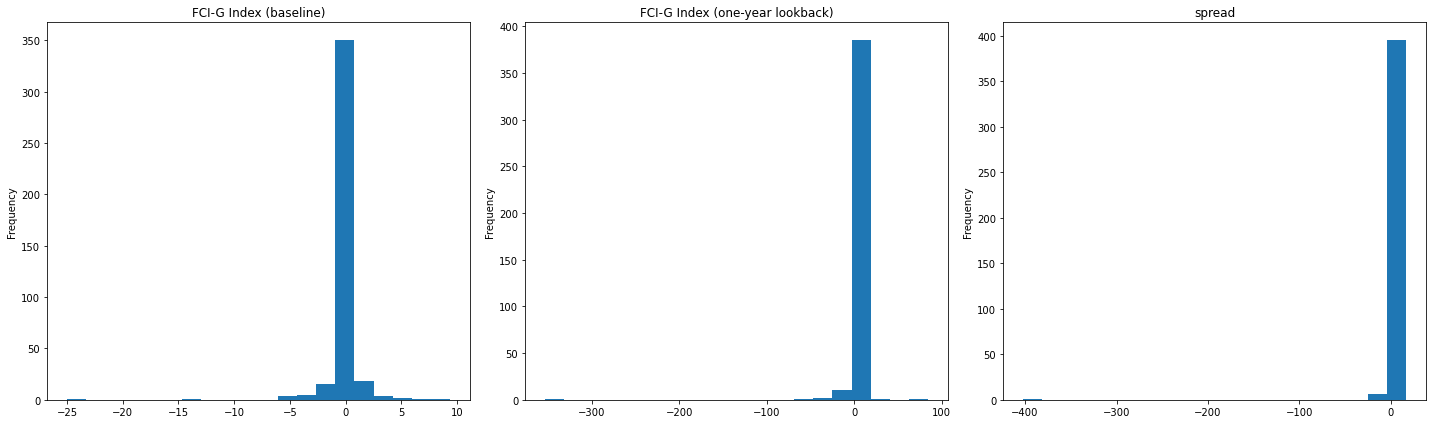

In [70]:
fig, axes = plt.subplots(ncols = 3, figsize = (20,6))
for i, col in enumerate(df_pct_change.columns):
    
    (df_pct_change[
        col].
        plot(
            ax = axes[i],
            kind = "hist",
            title = col,
            bins = 20))
    
plt.tight_layout()

Let's do a z-score drop

In [81]:
def _abs_z_score(df: pd.DataFrame) -> pd.DataFrame:
    return(df.assign(
        abs_z_score = lambda x: np.abs((x.value - x.value.rolling(window = 10).mean()) / x.value.rolling(window = 10).std())))

df_pct_change_z = (df_pct_change.reset_index().melt(
    id_vars = "date").
    dropna().
    groupby("variable").
    apply(_abs_z_score).
    dropna().
    query("abs_z_score < 2").
    drop(columns = ["abs_z_score"]).
    pivot(index = "date", columns = "variable", values = "value"))

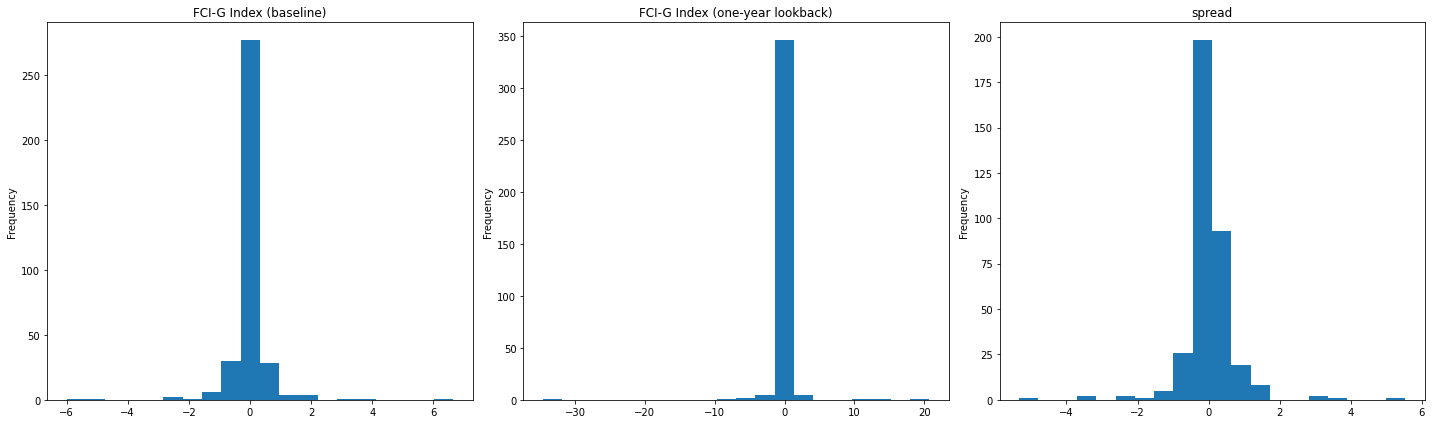

In [82]:
fig, axes = plt.subplots(ncols = 3, figsize = (20,6))
for i, col in enumerate(df_pct_change_z.columns):
    
    (df_pct_change_z[
        col].
        plot(
            ax = axes[i],
            kind = "hist",
            title = col,
            bins = 20))
    
plt.tight_layout()

I still don't like the plots they exhibit a high amount of kurtosis and fat left tails. 

# QQ Plot

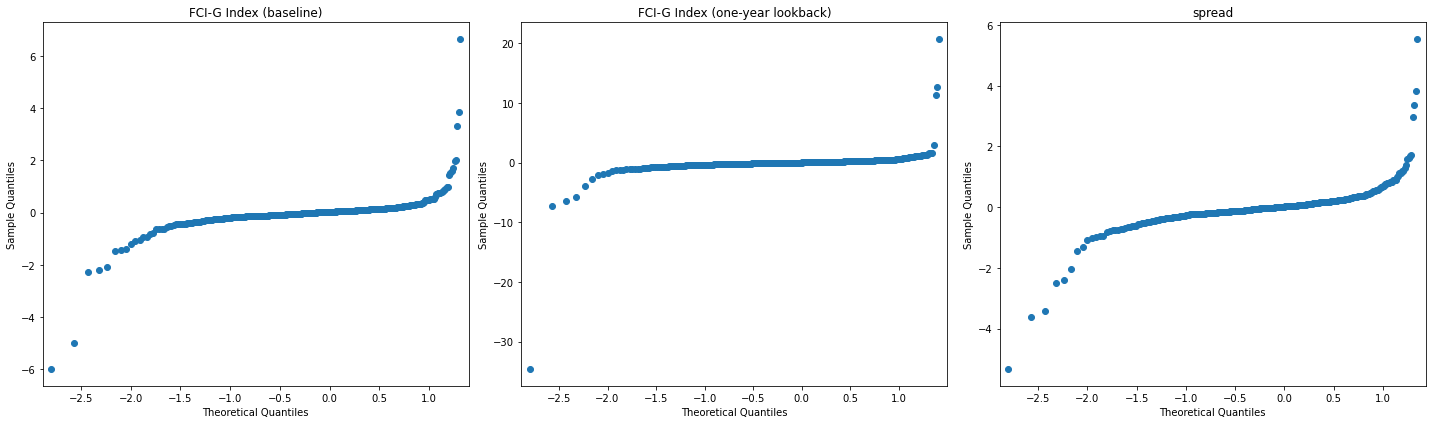

In [85]:
fig, axes = plt.subplots(ncols = 3, figsize = (20,6))
for i, col in enumerate(df_pct_change_z.columns):
    
    sm.qqplot(
        df_pct_change_z[col],
        ax = axes[i])
    
    axes[i].set_title(col)
    
plt.tight_layout()